In [ ]:
%load_ext autoreload
%autoreload 2

IMPORT SECTION

In [ ]:
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

IMPORT UTILS

In [ ]:
from utils.ml_utils import split_to_train_and_test, get_classifier_obj, calc_evaluation_val
from utils.curation_utils import transfer_to_categorical, remove_duplicates_and_drop_na, repair_numeric_missing_vals, \
    outlier_detection_iqr, my_dist_to_avg
from utils.plot_utils import plot_frequent_elements, plot_cross_tabulation, get_highly_correlated_cols, \
    transfer_str_to_numeric_vals
from utils.general_utls import load_dataset

LOAD DATASET

In [27]:
file_name = "huge_dataset.csv"
dataset_file_path = osp.join(osp.dirname(osp.abspath("__file__")), file_name)
dataset = load_dataset(dataset_file_path)
dataset.common_genre = dataset.common_genre.astype('category')
print(f"SHAPE: {dataset.shape}\n")
dataset.info()

SHAPE: (15400, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15400 entries, 0 to 15399
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   source_genre        15400 non-null  object  
 1   name                15400 non-null  object  
 2   artists             15400 non-null  object  
 3   release_year        15400 non-null  int64   
 4   release_month       14721 non-null  float64 
 5   genres              15400 non-null  object  
 6   common_genre        15399 non-null  category
 7   duration            15400 non-null  int64   
 8   popularity          15400 non-null  int64   
 9   lyrics_file         15400 non-null  object  
 10  lyrics_url          15400 non-null  object  
 11  intro_cnt           12306 non-null  float64 
 12  outro_cnt           12306 non-null  float64 
 13  verse_cnt           12306 non-null  float64 
 14  chorus_cnt          12306 non-null  float64 
 15  line_cnt        

 DATA VISUALIZATION

Let us examine the individual columns in the data.
The data contains the following fields:
- release_year - Ordinal
- release_month - Ordinal
- common_genre - Category
- duration - Numeric
- popularity - Ordinal
- line_cnt - Numeric
- word_cnt - Numeric
- unique_words_ratio - Ordinal (Norm.)
- stop_words_ratio - Ordinal (Norm.)
- slang_words_ratio - Ordinal (Norm.)
- negative - Ordinal (Norm.)
- positive - Ordinal (Norm.)
- neutral - Ordinal (Norm.)
- compound - Ordinal (Norm.)
- intro_cnt - Ordinal
- outro_cnt - Ordinal
- verse_cnt - Ordinal
- chorus_cnt - Ordinal


We will visualize differently the types of variables:
- Categorial - as Pie Chart
- Oridnal - as Bar Chart
- Numeric or Normalized Ordinal - as Histogram

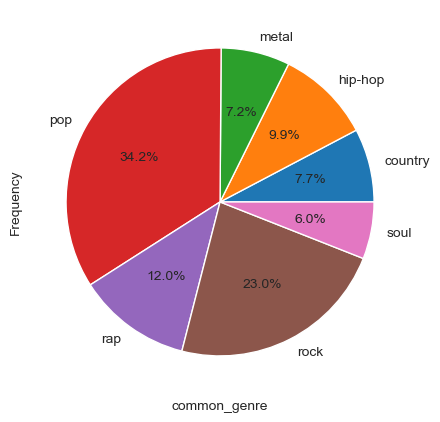

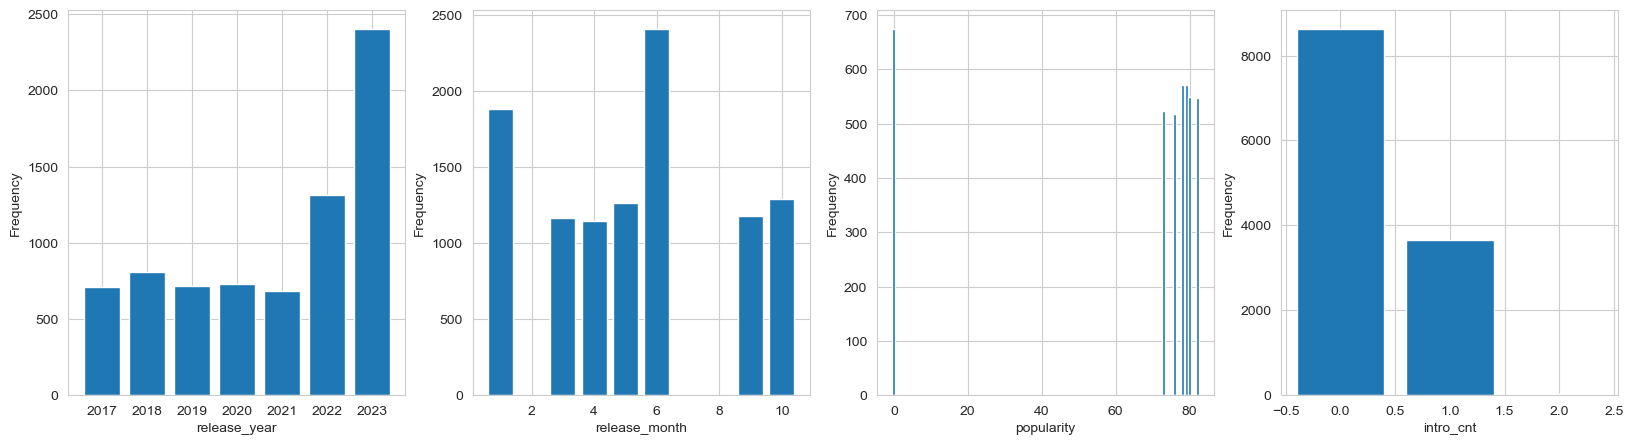

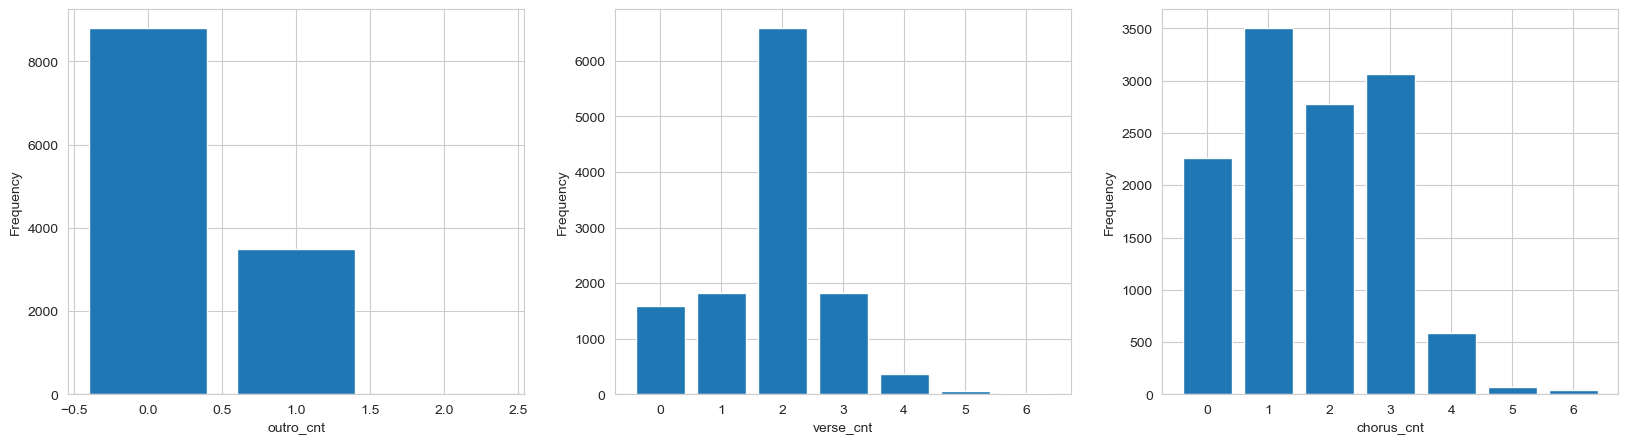

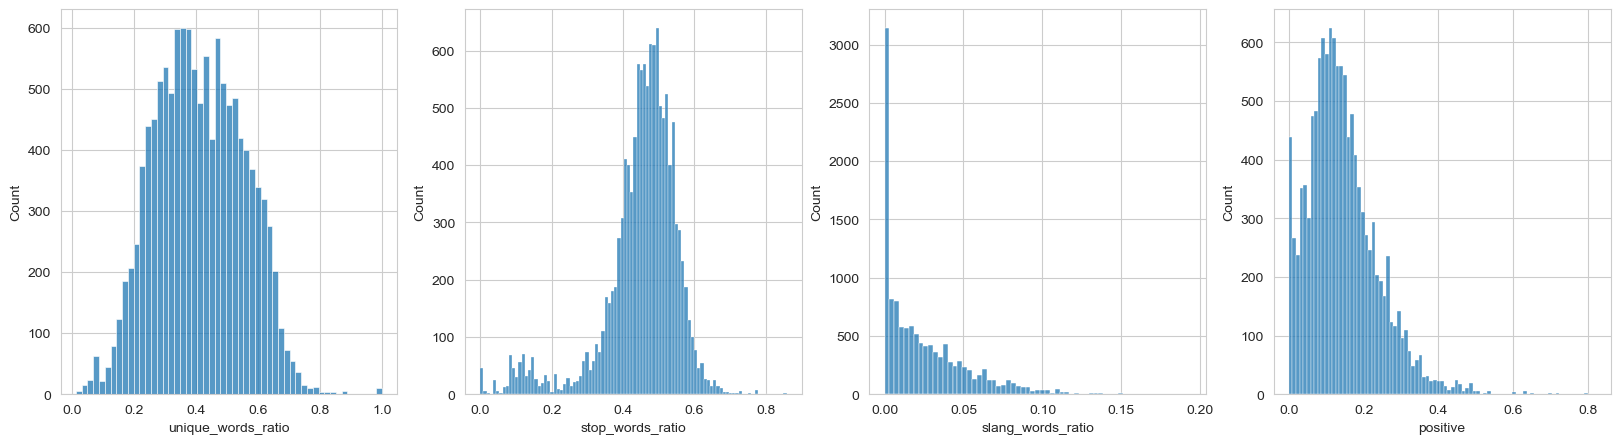

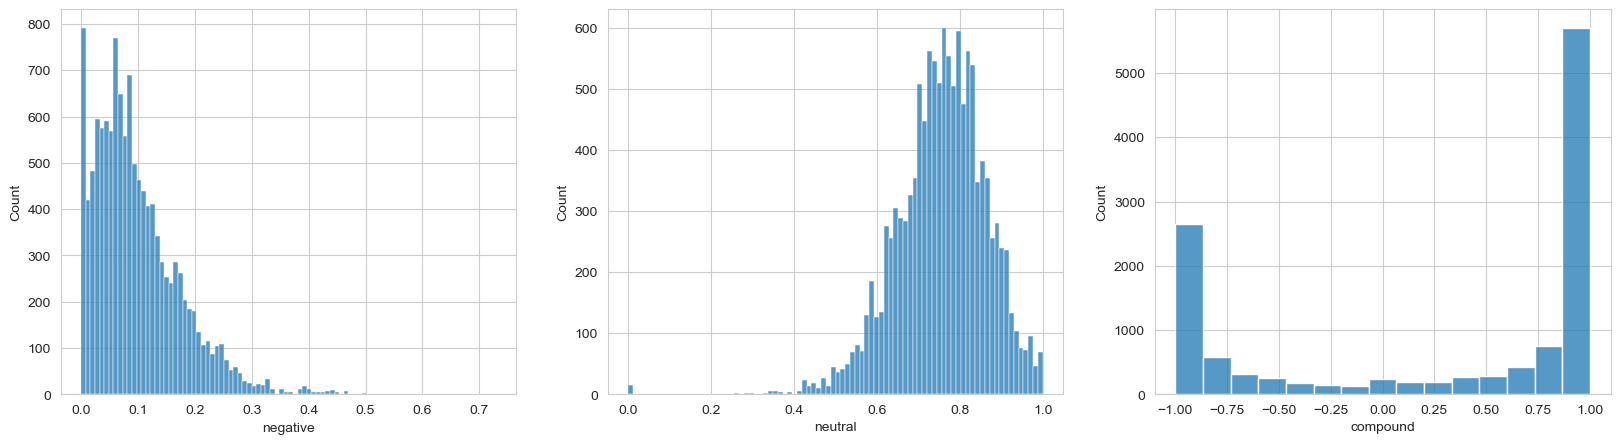

In [31]:
plot_frequent_elements(
    dataset,
    pd.DataFrame({
        'plot_type': ['pie'],
        'col_name': ['common_genre'],
        'num_top_elements': [7]
    })
)

ordinal_cols = ['release_year', 'release_month', 'popularity',
                'intro_cnt', 'outro_cnt', 'verse_cnt', 'chorus_cnt']
cols = min(len(ordinal_cols), 4)
rows = math.ceil((len(ordinal_cols) / 4))

for dummy in range(rows):
    sub_list = ordinal_cols[dummy*cols:(dummy+1)*cols]
    plot_frequent_elements(
        dataset,
        pd.DataFrame({
            'plot_type': ['bar'] * len(sub_list),
            'col_name': sub_list,
            'num_top_elements': [7] * len(sub_list)
        })
    )

numeric_cols =['unique_words_ratio', 'stop_words_ratio', 'slang_words_ratio',
               'positive', 'negative', 'neutral', 'compound']
cols = min(len(numeric_cols), 4)
rows = math.ceil((len(numeric_cols) / 4))

for ridx in range(rows):
    fig, axs = plt.subplots(1, min(cols, len(numeric_cols) - ridx*4), figsize=(20, 5))
    axs = np.array(axs).reshape(-1)
    for i, col in enumerate(numeric_cols[ridx*4:(ridx+1)*4]):
        sns.histplot(dataset[col], ax=axs[i])

# COMMON GENRE FEATURE RELATIONS VISUALIZATION

IndexError: index 3 is out of bounds for axis 0 with size 3

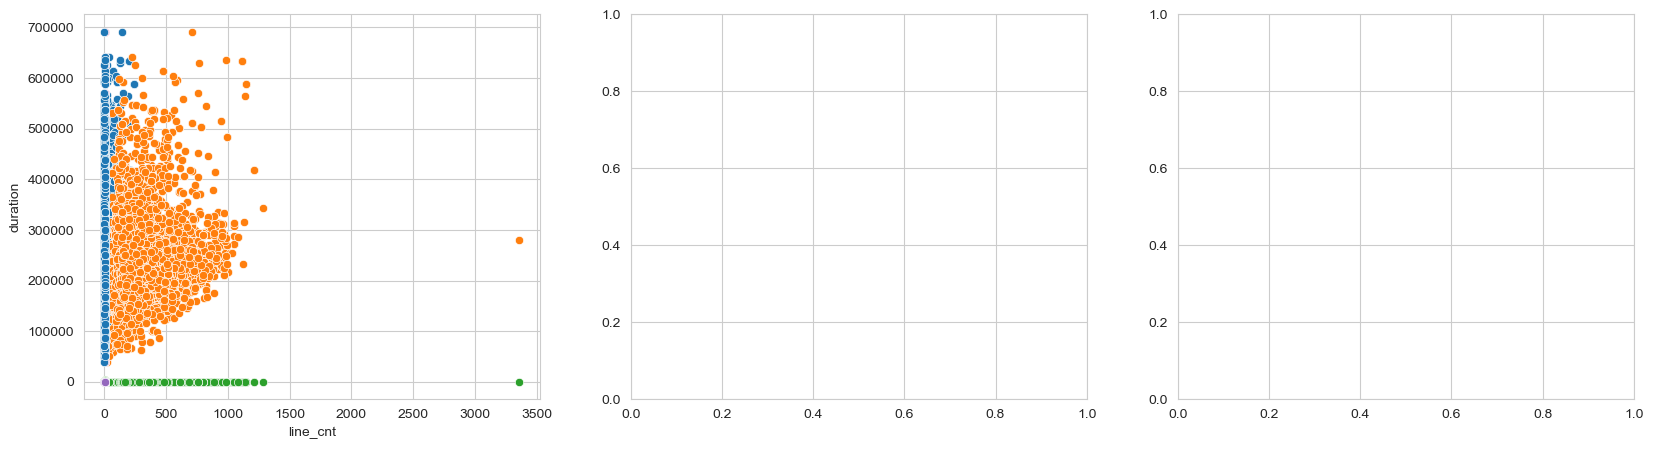

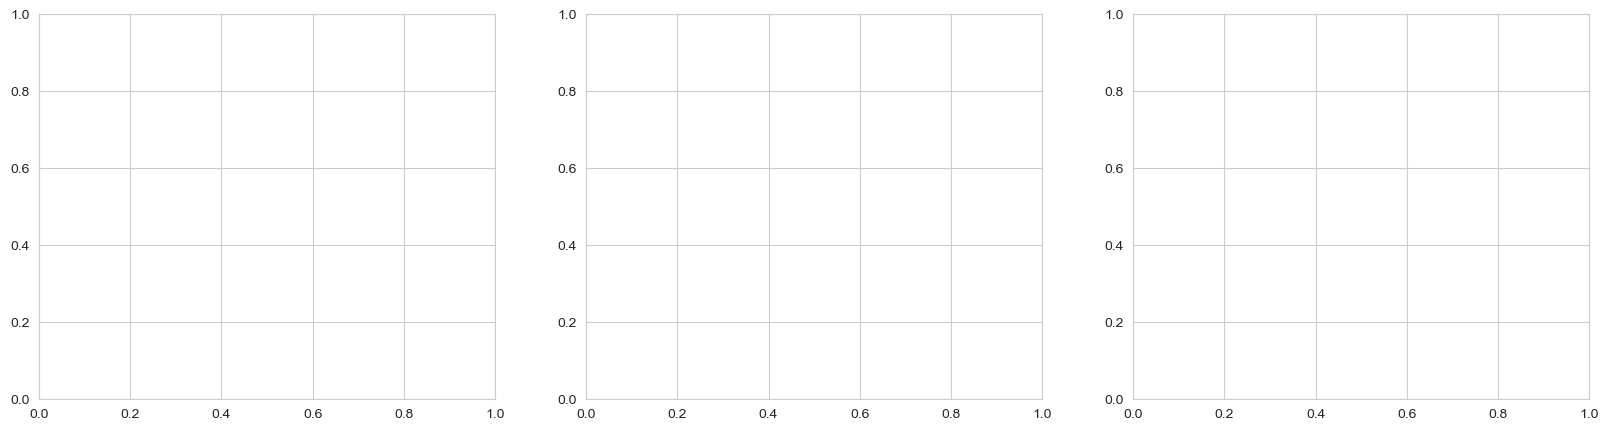

In [66]:
continuous_vars = ["duration", "line_cnt", "word_cnt", "unique_words_ratio", "stop_words_ratio", "slang_words_ratio"]

cols = 3
vals = (len(continuous_vars)**2-len(continuous_vars))/2
rows = math.ceil(vals/cols)

for ridx in range(rows):
    fig, axs = plt.subplots(1, min(cols, vals - ridx*cols), figsize=(20, 5))
    axes = axes.flatten()
    for i, feature in enumerate(continuous_vars):
        for j, feature2 in enumerate(continuous_vars):
            if i > j:
                ax = axs[(i * cols + j)*ridx]
                sns.scatterplot(x=dataset[feature], y=dataset[feature2], ax=ax)


# MISSING VALUES & OUTLIERS HUNT
As part of the data manipulation process, let's test the data's missing values, and look for outlier values

In [ ]:
missing_values = (dataset.isna() | dataset.isnull()).sum() / len(dataset)
missing_values = missing_values[missing_values>0]
plt.figure(figsize=(18, 6))
plt.xticks(rotation=45)
plt.title("Missing values per Column (ratio, non-zero)")
plt.bar(missing_values.index, missing_values.values, width=0.2)

## Analysis - missing values
Some records don't have the release_month field set. This is because the original released date in the dataset included the release year only. Since this is a not-so-significant amount of data, we will get rid of these lines

In [ ]:
dataset_1 = dataset.dropna(axis="index", subset=["release_month"])
len(dataset_1)/len(dataset)

CLEAN DATASET

In [ ]:
dup_na_removed = remove_duplicates_and_drop_na(dataset)
outliers = outlier_detection_iqr(dup_na_removed, my_dist_to_avg)
repaired = repair_numeric_missing_vals(outliers, dup_na_removed.select_dtypes('number'))
repaired.info()

In [ ]:
# pd.plotting.scatter_matrix(repaired, figsize = (20,20))

In [ ]:
numeric_to_bin_dict = {
    "duration": [0, 150000, 300000, 450000, 600000, 750000],
    "popularity": [0, 20, 40, 60, 80, 100],
    "line_cnt": [0, 50, 100, 150, 200, 250],
    "word_cnt": [0, 300, 600, 900, 1200, 1500],
    "unique_words_ratio": [0, 100, 200, 300, 400, 500],
    "stop_words_ratio": [-1, 150, 300, 450, 600, 750],
}

categorical_cols = ['chorus_cnt', 'verse_cnt']
transferred = transfer_to_categorical(repaired, numeric_to_bin_dict, categorical_cols)

In [ ]:
transferred.info()

EDA SECTION

In [ ]:
df_params = pd.DataFrame({'plot_type': ['bar', 'line', 'pie'],
                          'col_name': ['common_genre', 'release_year', 'artists'],
                          'num_top_elements': [6,6,6]})
plot_frequent_elements(transferred, df_params)

In [ ]:
plt.rcParams["figure.figsize"] = (18,6)

In [ ]:
print("\nCommon Genre Distribution:")
sns.countplot(x='common_genre', data=transferred)
plt.show()

In [ ]:
numerical_cols = ['duration','popularity', 'line_cnt', 'word_cnt', 'unique_words_ratio',
                  'stop_words_ratio']
for col in numerical_cols:
    sns.histplot(transferred[col])
    plt.title(col + " Distribution")
    plt.show()

In [ ]:
sentiment_cols = ['negative', 'neutral', 'positive', 'compound']
for col in sentiment_cols:
    sns.histplot(transferred[col])
    plt.title(col + " Distribution")
    plt.show()

In [ ]:
# cross_tabulation(transferred, 'release_date', 'popularity')
plot_cross_tabulation(transferred, ['release_month', 'popularity'], 'common_genre')

In [ ]:
correlations, tuple_arr = get_highly_correlated_cols(transferred)

In [ ]:
cols_for_correlations = transferred.columns
indx_sort = np.argsort(correlations)
for n_correlation in indx_sort:
    col_lt, col_rt = tuple_arr[n_correlation]
    col_name_lt, col_name_rt = cols_for_correlations[col_lt], cols_for_correlations[col_rt]
    title = "corr('%s', '%s')=%4.2f" %(col_name_lt, col_name_rt, correlations[n_correlation])
    print(title)

In [ ]:
transferred = transfer_str_to_numeric_vals(transferred)
transferred.info()

In [ ]:
prepared = transferred.drop(
    columns=[
        'genres', 'source_genre',
        'name', 'lyrics_file',
        'lyrics_url', 'popularity',
        'compound', 'neutral',
        'line_cnt'
    ],
    axis=1
)

In [ ]:
prepared.info()

In [ ]:
X_train, X_test, y_train, y_test = split_to_train_and_test(prepared, 'common_genre', 0.2, 5)

params = {'n_neighbors':23}
clf = get_classifier_obj("KNN",params)
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [ ]:
accuracy_val = calc_evaluation_val("accuracy", y_test, y_predicted)
print(accuracy_val)
# matrix = calc_evaluation_val("confusion_matrix", y_test, y_predicted)
# print(matrix)
# recall_val = calc_evaluation_val("recall", y_test, y_predicted)
# print(recall_val)
# f1_val = calc_evaluation_val("f1", y_test, y_predicted)
# print(f1_val)
# confusion_matrix_val = calc_evaluation_val("confusion_matrix", y_test, y_predicted)